In [1]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

Cloning into 'MasterArbeit'...
remote: Enumerating objects: 2087, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 2087 (delta 4), reused 7 (delta 2), pack-reused 2075 (from 1)
Receiving objects: 100% (2087/2087), 977.06 MiB | 16.49 MiB/s, done.
Resolving deltas: 100% (1029/1029), done.
Updating files: 100% (179/179), done.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

DATASET_NAME = 'CIFAR10'    # CIFAR10, CIFAR100
DATASET_TYPE = 'custom'   # baseline, custom
EPOCHS = 100
BATCH_SIZE = 512
ENABLE_TPU = False

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')
    

print(f'Hyperparameters:\n\tDataset: {DATASET_NAME}\n\tType: {DATASET_TYPE}\n\tEpochs: {EPOCHS}\n\tTPU Enabled: {ENABLE_TPU}')

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']
Hyperparameters:
	Dataset: CIFAR10
	Type: custom
	Epochs: 100
	TPU Enabled: False


In [3]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = ENABLE_TPU

if tpu == True:
    print('TPU is Enabled')
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = BATCH_SIZE

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
    
%cd /kaggle/working/MasterArbeit
from augment_dataset import create_transforms, load_data
from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=True, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
%cd

classes = baseline_trainset.classes


Loading CIFAR10...



100%|██████████| 170498071/170498071 [00:10<00:00, 15838003.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
/kaggle/working/MasterArbeit


100%|██████████| 170498071/170498071 [00:10<00:00, 15797218.40it/s]


Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


100%|██████████| 170498071/170498071 [00:10<00:00, 15852866.72it/s]


Extracting ./data/test/cifar-10-python.tar.gz to ./data/test
/root


In [4]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
)


Dataset type "custom" displaying...

automobile: 1.00 dog  : 0.61 truck: 0.98 automobile: 0.95 horse: 1.00 deer : 1.00 truck: 0.96 automobile: 0.86 bird : 0.99 deer : 0.89 airplane: 1.00 automobile: 0.57 airplane: 1.00 cat  : 1.00 deer : 0.50 automobile: 1.00 deer : 0.60 horse: 0.56 airplane: 0.50 cat  : 0.99 dog  : 0.95 airplane: 0.94 cat  : 1.00 bird : 1.00 bird : 0.99 dog  : 0.95 deer : 1.00 bird : 0.77 truck: 0.97 automobile: 1.00 automobile: 0.83 deer : 0.84 frog : 1.00 frog : 0.68 airplane: 1.00 ship : 0.99 ship : 0.94 bird : 1.00 deer : 1.00 cat  : 1.00 cat  : 0.55 dog  : 0.82 cat  : 1.00 bird : 0.69 frog : 0.85 automobile: 0.50 frog : 0.50 automobile: 0.72 dog  : 0.50 dog  : 1.00 bird : 0.99 deer : 1.00 bird : 0.64 truck: 0.50 dog  : 1.00 horse: 0.98 cat  : 0.92 ship : 1.00 automobile: 1.00 dog  : 0.52 airplane: 0.58 horse: 0.50 cat  : 1.00 frog : 0.98 airplane: 0.64 airplane: 1.00 ship : 0.83 truck: 0.99 airplane: 0.50 dog  : 0.99 frog : 1.00 frog : 0.98 horse: 0.86 deer : 0.9

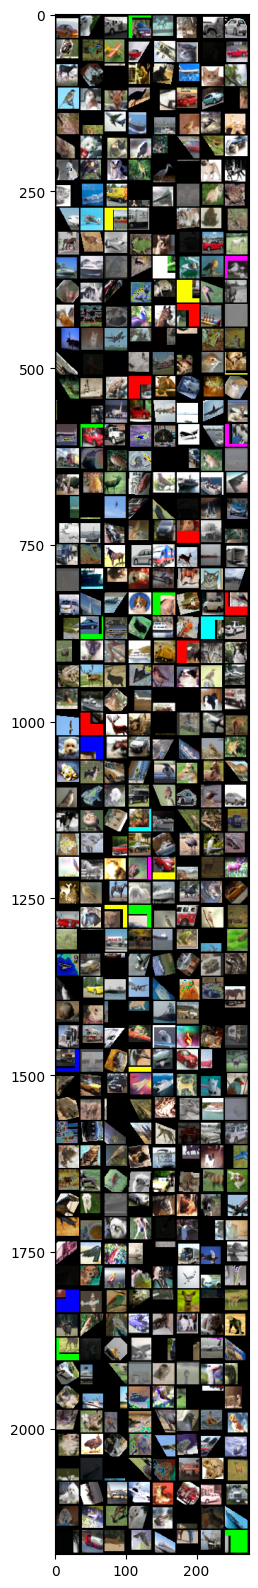

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [8]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [9]:
def soft_loss(pred, label, confidence):
    log_prob = F.log_softmax(pred, dim=1)
    # print(f'log_prob: {log_prob.shape}')
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    # print(f'label: {label.shape}')
    confidence = confidence.unsqueeze(1).float()
    # print(f'confidence: {confidence.shape}')
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    # print(f'one_hot: {one_hot.shape}')
    one_hot.scatter_(dim=1, index=label, src=confidence)
    # print(f'one_hot: {one_hot.shape}')

    # Compute weighted KL loss
    kl_uw = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)
    kl_uw = kl_uw.unsqueeze(1)
    # print(f'kl_unweighted: {kl_uw.shape}')                   # Unweighted
    kl = confidence * kl_uw  # Weighted
    # print(f'kl: {kl.shape}')
    return kl.mean()

In [10]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.15, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_accuracies = [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    confidences = None
    
    net.train()
    
    # for i, (inputs, labels) in enumerate(baseline_trainloader):
    for i, (inputs, labels, confidences) in enumerate(custom_trainloader):
        if DATASET_TYPE=='custom' and confidences is None:
            raise ValueError('Dataset type do not match data loader')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        """when the model returns [augmentation_magnitude, confidence_aa], which is the case
        only when TA with soft labels is applied."""
            
        # get the inputs
        if isinstance(confidences, list):
            confidences = confidences[1]
            
        confidences = confidences.to(device)
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
        # labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        
        if DATASET_TYPE=='custom':
            loss = soft_loss(pred=outputs, label=labels, confidence=confidences)
#             loss = smooth_crossentropy(pred=outputs, gold=labels)
        else:
            loss = criterion(outputs, labels)
            
        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_loss)
    
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Loss: {average_loss:.3f} - Test Accuracy: {100 * test_accuracy: .3f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 1 - Loss: 1.266 - Test Accuracy:  28.010

Processing time:  49.094369 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 2 - Loss: 1.030 - Test Accuracy:  41.980

Processing time:  47.981671 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 3 - Loss: 0.869 - Test Accuracy:  54.770

Processing time:  47.961600 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 4 - Loss: 0.766 - Test Accuracy:  56.150

Processing time:  48.239330 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 5 - Loss: 0.698 - Test Accuracy:  57.530

Processing time:  48.179461 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 6 - Loss: 0.634 - Test Accuracy:  47.560

Processing time:  47.837008 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 7 - Loss: 0.595 - Test Accuracy:  64.910

Processing time:  47.921404 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 8 - Loss: 0.556 - Test Accuracy:  67.120

Processing time:  47.951931 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 9 - Loss: 0.519 - Test Accuracy:  63.570

Processing time:  47.940832 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 10 - Loss: 0.488 - Test Accuracy:  72.690

Processing time:  48.003659 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 11 - Loss: 0.468 - Test Accuracy:  80.670

Processing time:  48.105649 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 12 - Loss: 0.443 - Test Accuracy:  74.230

Processing time:  48.786849 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 13 - Loss: 0.429 - Test Accuracy:  79.260

Processing time:  48.484538 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 14 - Loss: 0.407 - Test Accuracy:  66.680

Processing time:  47.971107 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 15 - Loss: 0.403 - Test Accuracy:  82.360

Processing time:  48.029425 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 16 - Loss: 0.380 - Test Accuracy:  69.660

Processing time:  47.814074 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 17 - Loss: 0.374 - Test Accuracy:  75.990

Processing time:  48.170915 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 18 - Loss: 0.358 - Test Accuracy:  83.130

Processing time:  48.129424 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 19 - Loss: 0.345 - Test Accuracy:  81.100

Processing time:  48.012468 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 20 - Loss: 0.339 - Test Accuracy:  83.410

Processing time:  47.895070 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 21 - Loss: 0.329 - Test Accuracy:  80.340

Processing time:  48.171473 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 22 - Loss: 0.327 - Test Accuracy:  84.390

Processing time:  47.925286 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 23 - Loss: 0.317 - Test Accuracy:  85.980

Processing time:  48.046268 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 24 - Loss: 0.306 - Test Accuracy:  84.400

Processing time:  47.938251 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 25 - Loss: 0.299 - Test Accuracy:  85.330

Processing time:  47.952709 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 26 - Loss: 0.296 - Test Accuracy:  85.960

Processing time:  47.988453 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 27 - Loss: 0.287 - Test Accuracy:  87.170

Processing time:  47.855847 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 28 - Loss: 0.280 - Test Accuracy:  80.900

Processing time:  47.824720 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 29 - Loss: 0.275 - Test Accuracy:  83.800

Processing time:  47.777258 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 30 - Loss: 0.268 - Test Accuracy:  84.300

Processing time:  47.941832 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 31 - Loss: 0.266 - Test Accuracy:  87.420

Processing time:  47.861316 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 32 - Loss: 0.259 - Test Accuracy:  87.520

Processing time:  47.934651 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 33 - Loss: 0.253 - Test Accuracy:  84.020

Processing time:  47.847243 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 34 - Loss: 0.251 - Test Accuracy:  88.180

Processing time:  47.734176 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 35 - Loss: 0.245 - Test Accuracy:  87.060

Processing time:  47.915241 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 36 - Loss: 0.241 - Test Accuracy:  85.830

Processing time:  47.710922 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 37 - Loss: 0.234 - Test Accuracy:  87.340

Processing time:  47.769045 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 38 - Loss: 0.227 - Test Accuracy:  87.400

Processing time:  47.826436 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 39 - Loss: 0.222 - Test Accuracy:  86.830

Processing time:  47.928467 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 40 - Loss: 0.222 - Test Accuracy:  87.570

Processing time:  47.822085 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 41 - Loss: 0.216 - Test Accuracy:  85.420

Processing time:  47.821692 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 42 - Loss: 0.214 - Test Accuracy:  90.210

Processing time:  48.370941 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 43 - Loss: 0.210 - Test Accuracy:  89.030

Processing time:  47.946311 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 44 - Loss: 0.201 - Test Accuracy:  87.160

Processing time:  48.051369 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 45 - Loss: 0.203 - Test Accuracy:  90.080

Processing time:  47.921941 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 46 - Loss: 0.196 - Test Accuracy:  89.280

Processing time:  48.544034 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 47 - Loss: 0.191 - Test Accuracy:  88.440

Processing time:  47.858598 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 48 - Loss: 0.188 - Test Accuracy:  89.970

Processing time:  47.919091 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 49 - Loss: 0.182 - Test Accuracy:  90.070

Processing time:  47.977979 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 50 - Loss: 0.182 - Test Accuracy:  90.520

Processing time:  48.068229 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 51 - Loss: 0.176 - Test Accuracy:  90.580

Processing time:  48.368897 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 52 - Loss: 0.171 - Test Accuracy:  90.120

Processing time:  48.015815 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 53 - Loss: 0.171 - Test Accuracy:  90.640

Processing time:  47.793555 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 54 - Loss: 0.167 - Test Accuracy:  90.830

Processing time:  48.300915 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 55 - Loss: 0.166 - Test Accuracy:  89.940

Processing time:  48.270775 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 56 - Loss: 0.158 - Test Accuracy:  91.150

Processing time:  48.048139 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 57 - Loss: 0.157 - Test Accuracy:  91.770

Processing time:  48.837789 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 58 - Loss: 0.152 - Test Accuracy:  92.310

Processing time:  48.111285 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 59 - Loss: 0.151 - Test Accuracy:  92.520

Processing time:  48.137764 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 60 - Loss: 0.146 - Test Accuracy:  92.860

Processing time:  47.707992 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 61 - Loss: 0.143 - Test Accuracy:  92.780

Processing time:  48.065430 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 62 - Loss: 0.142 - Test Accuracy:  92.180

Processing time:  47.944103 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 63 - Loss: 0.140 - Test Accuracy:  93.200

Processing time:  48.064188 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 64 - Loss: 0.134 - Test Accuracy:  92.910

Processing time:  47.918444 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 65 - Loss: 0.133 - Test Accuracy:  92.210

Processing time:  47.983378 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 66 - Loss: 0.129 - Test Accuracy:  92.500

Processing time:  47.742443 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 67 - Loss: 0.125 - Test Accuracy:  93.760

Processing time:  47.771551 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 68 - Loss: 0.125 - Test Accuracy:  93.600

Processing time:  47.738955 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 69 - Loss: 0.120 - Test Accuracy:  93.000

Processing time:  48.745308 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 70 - Loss: 0.123 - Test Accuracy:  92.980

Processing time:  48.106885 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 71 - Loss: 0.119 - Test Accuracy:  93.130

Processing time:  47.778737 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 72 - Loss: 0.117 - Test Accuracy:  93.590

Processing time:  47.966079 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 73 - Loss: 0.113 - Test Accuracy:  93.860

Processing time:  47.982666 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 74 - Loss: 0.113 - Test Accuracy:  93.500

Processing time:  48.483913 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 75 - Loss: 0.112 - Test Accuracy:  93.580

Processing time:  48.486984 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 76 - Loss: 0.108 - Test Accuracy:  93.740

Processing time:  47.968667 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 77 - Loss: 0.105 - Test Accuracy:  93.610

Processing time:  48.144423 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 78 - Loss: 0.107 - Test Accuracy:  93.960

Processing time:  48.101567 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 79 - Loss: 0.105 - Test Accuracy:  93.890

Processing time:  47.977055 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 80 - Loss: 0.102 - Test Accuracy:  93.870

Processing time:  47.958643 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 81 - Loss: 0.099 - Test Accuracy:  94.030

Processing time:  48.349226 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 82 - Loss: 0.100 - Test Accuracy:  94.070

Processing time:  48.051671 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 83 - Loss: 0.099 - Test Accuracy:  94.050

Processing time:  48.105438 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 84 - Loss: 0.097 - Test Accuracy:  93.930

Processing time:  48.098207 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 85 - Loss: 0.097 - Test Accuracy:  94.250

Processing time:  48.048293 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 86 - Loss: 0.093 - Test Accuracy:  94.420

Processing time:  48.165920 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 87 - Loss: 0.093 - Test Accuracy:  94.440

Processing time:  48.107767 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 88 - Loss: 0.093 - Test Accuracy:  94.490

Processing time:  48.693871 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 89 - Loss: 0.094 - Test Accuracy:  94.210

Processing time:  48.042663 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 90 - Loss: 0.091 - Test Accuracy:  94.500

Processing time:  48.457684 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 91 - Loss: 0.092 - Test Accuracy:  94.600

Processing time:  48.098637 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 92 - Loss: 0.090 - Test Accuracy:  94.460

Processing time:  48.443883 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 93 - Loss: 0.091 - Test Accuracy:  94.510

Processing time:  48.244395 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 94 - Loss: 0.088 - Test Accuracy:  94.510

Processing time:  48.108254 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 95 - Loss: 0.092 - Test Accuracy:  94.610

Processing time:  48.019553 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 96 - Loss: 0.089 - Test Accuracy:  94.450

Processing time:  47.939587 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 97 - Loss: 0.090 - Test Accuracy:  94.500

Processing time:  48.593610 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 98 - Loss: 0.091 - Test Accuracy:  94.540

Processing time:  48.608701 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 99 - Loss: 0.090 - Test Accuracy:  94.610

Processing time:  48.145487 seconds.


/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)
/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:231: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(batch, dtype=torch.float64)



Epoch 100 - Loss: 0.092 - Test Accuracy:  94.620

Processing time:  47.881804 seconds.
Finished Training


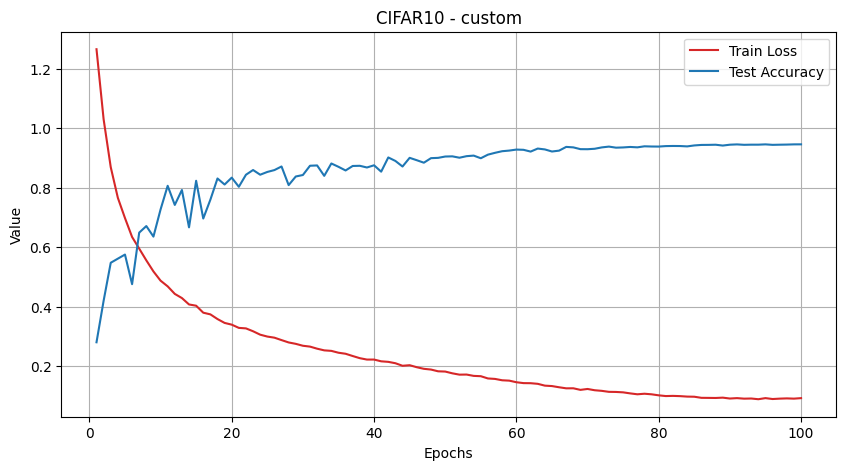

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model on Testset

In [12]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 94.62 %
Testing on corruption: gaussian_noise
Accuracy of the network on gaussian_noise dataset split 1: 86.13 %
Accuracy of the network on gaussian_noise dataset split 2: 74.74 %
Accuracy of the network on gaussian_noise dataset split 3: 59.72 %
Accuracy of the network on gaussian_noise dataset split 4: 52.07 %
Accuracy of the network on gaussian_noise dataset split 5: 44.97 %
Average accuracy for gaussian_noise dataset: 63.53 %
Testing on corruption: shot_noise
Accuracy of the network on shot_noise dataset split 1: 90.15 %
Accuracy of the network on shot_noise dataset split 2: 85.33 %
Accuracy of the network on shot_noise dataset split 3: 69.85 %
Accuracy of the network on shot_noise dataset split 4: 62.92 %
Accuracy of the network on shot_noise dataset split 5: 50.89 %
Average accuracy for shot_noise dataset: 71.83 %
Testing on corruption: impulse_noise
Accuracy of the network on impulse_noise dataset split 1: 90.87 %
Accuracy of

In [13]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=100)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/cifar100_net_ta_pytorch_200.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         if DATASET_NAME=='CIFAR10':
#             np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         elif DATASET_NAME=='CIFAR100':
#             np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
#         else:
#             raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")